In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)
sns.set()
import xgboost as xgb
import pickle
from haversine import haversine
from sklearn.model_selection import train_test_split
import warnings;warnings.simplefilter('ignore')

### The data has been explored earlier and I just add the code that modifies the data

In [10]:
data = pd.read_csv('train.csv')

In [12]:
# Anomalies are detected in trip_duration, remove some of them (which are less than 10K)
duration_mask = ((data.trip_duration < 60) | # < 1 min
             (data.trip_duration > 3600 * 2)) # > 2 hours

data = data[~duration_mask]
data.trip_duration = data.trip_duration.astype(np.uint16)
print('Trip duration in seconds: {} to {}'.format(data.trip_duration.min(), data.trip_duration.max()))


Trip duration in seconds: 60 to 7191


In [13]:
# Calculating Manhattan distance
def calc_distance(df):
    """ Convert trip distance to Manhattan distance"""
    pickup = (df.pickup_latitude, df.pickup_longitude)
    drop = (df.dropoff_latitude, df.dropoff_longitude)
    return haversine(pickup, drop)

data['distance'] = data.apply(lambda x: calc_distance(x), axis=1)

In [24]:
# We calculate speed in order to filter data with illogical speed
data['speed'] = (data.distance/(data.trip_duration/3600))

In [15]:
# filter data with respect to passengers
data = data[data.passenger_count<=6]

In [16]:
# Convert zero passenger_count to passenger_count = 1
data['passenger_count'] = data.passenger_count.apply(lambda x:1 if x==0 else x)

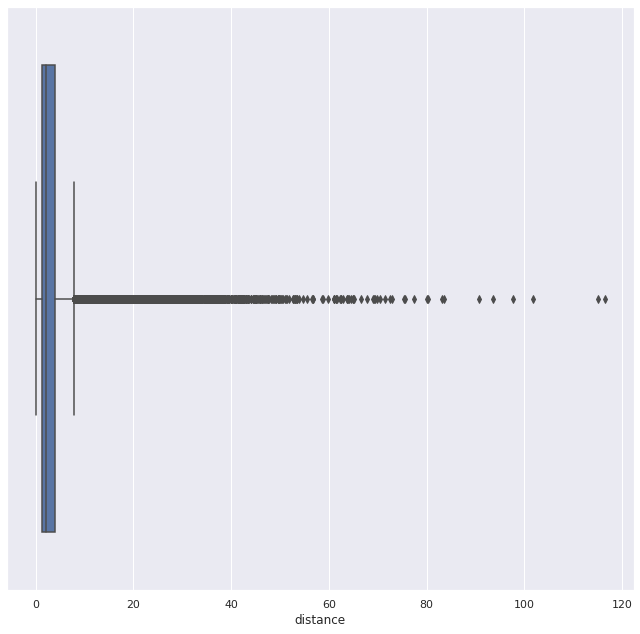

In [23]:
# Let's check data distribution with respect to distance
sns.boxplot(data.distance)

In [17]:
data.distance.describe()

count    1.447794e+06
mean     3.457912e+00
std      4.290755e+00
min      0.000000e+00
25%      1.244398e+00
50%      2.106278e+00
75%      3.892099e+00
max      1.240910e+03
Name: distance, dtype: float64

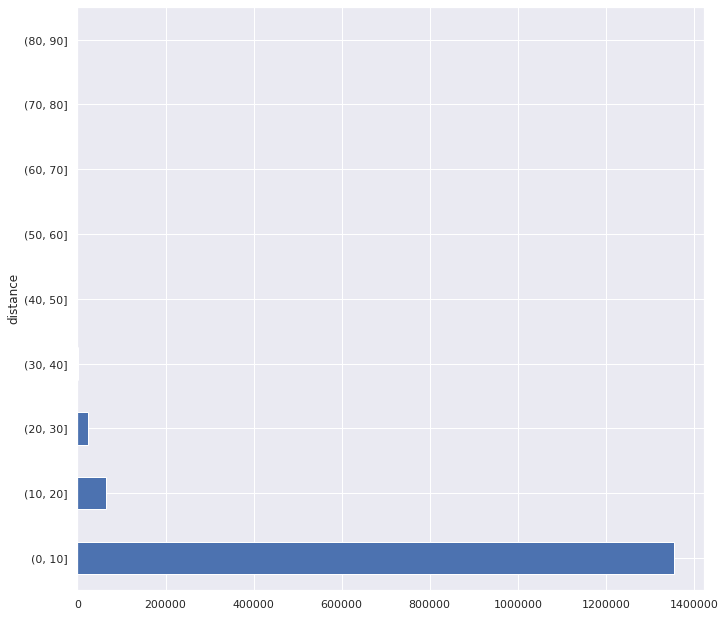

In [18]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,100, 10))).count().plot(kind='barh')

In [25]:
# Filter outliers by speed
data = data[data.speed <= 104]

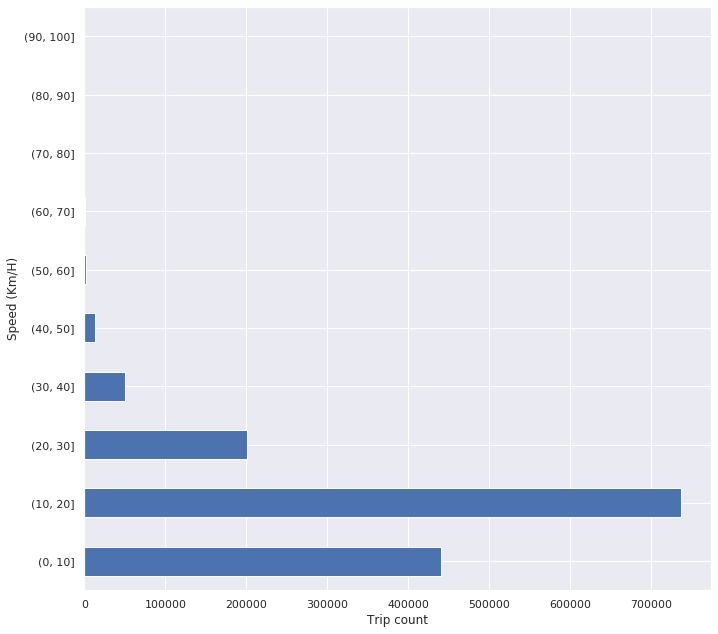

In [26]:
# We split the speed range to groups.
# Then count data rows in each group and compare the populations
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

In [27]:
# Map numbers instead of letters.
data.store_and_fwd_flag = data.store_and_fwd_flag.map({'N':0, 'Y':1})

In [28]:
# Convert datetime strings into datetime
data["dropoff_datetime"] = pd.to_datetime(data["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

# Now construct other variables, like month, date, etc.
data["pickup_month"] = data["pickup_datetime"].dt.month
data["pickup_day"] = data["pickup_datetime"].dt.day
data["pickup_weekday"] = data["pickup_datetime"].dt.weekday
data["pickup_hour"] = data["pickup_datetime"].dt.hour
data["pickup_minute"] = data["pickup_datetime"].dt.minute

In [31]:
# Locate the ones that have distance equal to 0KM and trip duration more than 60 seconds.
data.loc[((data.distance == 0) & (data.trip_duration >= 60)), ['distance','speed', 'trip_duration']].head(10)

,distance,speed,trip_duration
246,0.0,0.0,227
291,0.0,0.0,1109
407,0.0,0.0,947
702,0.0,0.0,580
1769,0.0,0.0,254
2087,0.0,0.0,248
2609,0.0,0.0,1212
3014,0.0,0.0,598
3610,0.0,0.0,604
4058,0.0,0.0,1325


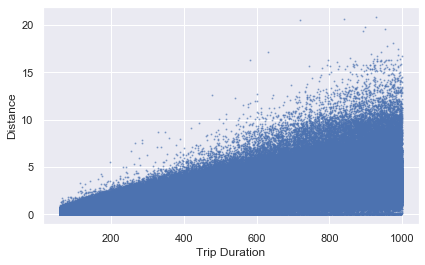

In [16]:
dur_dist = data.loc[(data.distance < 50) & (data.trip_duration < 1000),
                    ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

In [32]:
# Filter trips with distance equal to 0 KM and duration more than 1 minutes
# Assumption -> Trip was cancelled
data = data[~((data.distance == 0) & (data.trip_duration >= 60))]

In [33]:
# Filter trips with distance less than 1 KM which have duration more than 1 hour
# It's not consistent with data
data = data[~((data.distance <= 1) & (data.trip_duration >= 3600))]

In [34]:
data.shape

(1443410, 18)

In [35]:
def map_marker(set):
    # Import package for map
    from mpl_toolkits.basemap import Basemap
    plt.figure(figsize = (20,20))

    # Set the limits of the map to the minimum and maximum coordinates
    lat_min = data["pickup_latitude"].min() - .2
    lat_max = data["pickup_latitude"].max() + .2
    lon_min = data["pickup_longitude"].min() - .2
    lon_max = data["pickup_longitude"].max() + .2

    # Set the center of the map
    cent_lat = (lat_min + lat_max) / 2
    cent_lon = (lon_min + lon_max) / 2

    #Create the Basemap object with required params.
    map = Basemap(llcrnrlon=lon_min,
                  llcrnrlat=lat_min,
                  urcrnrlon=lon_max,
                  urcrnrlat=lat_max,
                  resolution='l',
                  projection='tmerc',
                  lat_0 = cent_lat,
                  lon_0 = cent_lon)

    #Style the map
    map.drawmapboundary()
    map.drawcoastlines()
    map.fillcontinents()
    map.drawcountries(linewidth=2)
    map.drawstates()


    #Fetch the long and lat in form of array
    long = np.array(data["pickup_longitude"])
    lat = np.array(data["pickup_latitude"])

    x, y = map(long, lat)
    map.plot(x, y,'ro', markersize=2, alpha=1)

    plt.show()

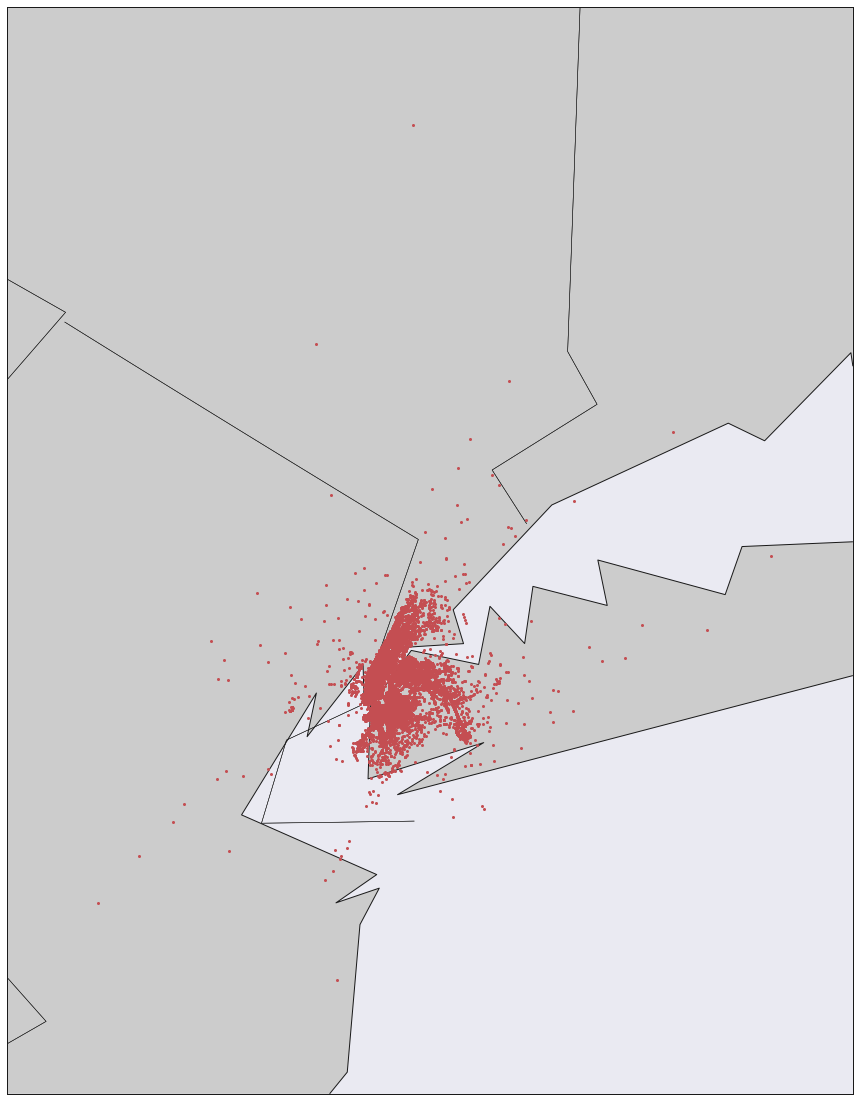

In [28]:
map_marker(data)

In [22]:
data[data.pickup_longitude == data.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,-121.933342,37.389381,-121.933304,37.389511,0,499,0.014811,0.106849,2,26,4,13,50


In [37]:
# trip duration is not in correlation with the distance covered
data = data[data.pickup_longitude != data.pickup_longitude.min()]

In [38]:
data[data.pickup_longitude == data.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute
1068810,id3777240,2,2016-01-27 18:26:40,2016-01-27 18:45:05,2,-121.933235,37.389297,-121.933205,37.389103,0,1105,0.0218,0.071024,1,27,2,18,26


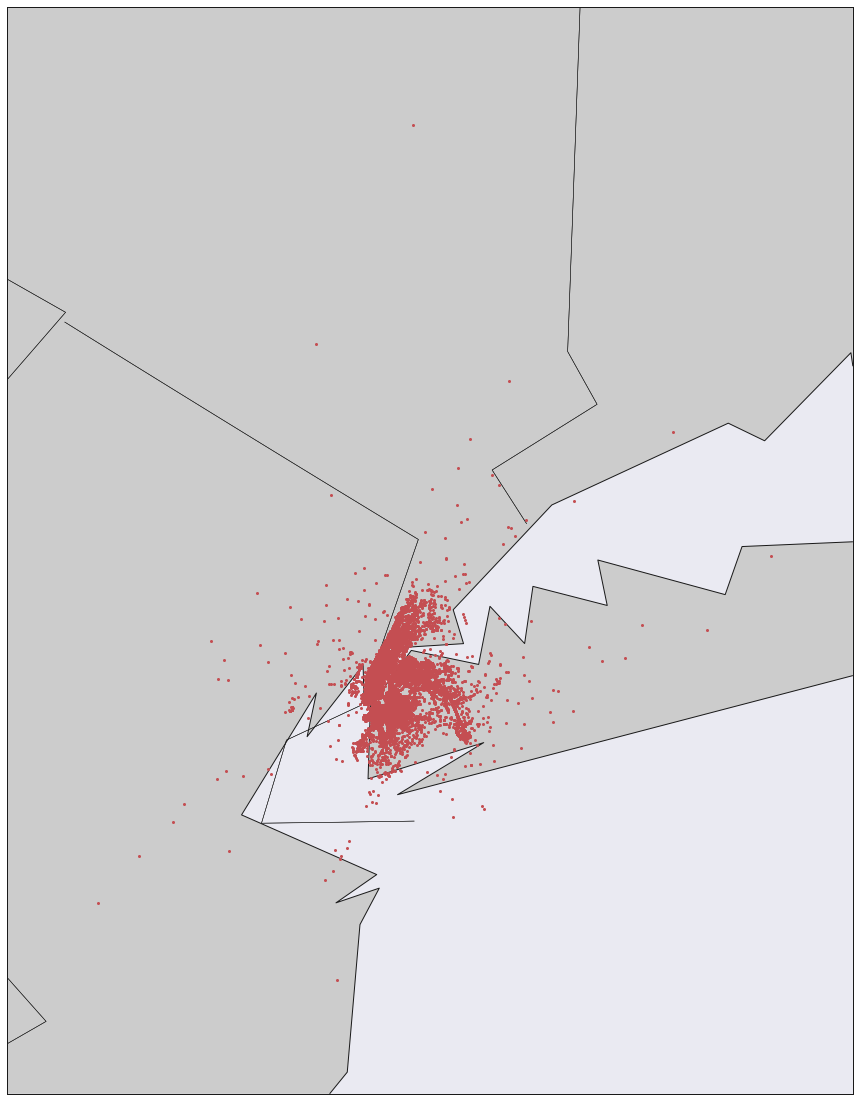

In [29]:
# Check again!
map_marker(data)

In [57]:
# The same story for this one!
data = data[data.pickup_longitude != data.pickup_longitude.min()]

In [59]:
# Generate new csv file for building a model
data[['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
     'passenger_count', 'pickup_longitude', 'pickup_latitude',
     'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
     'trip_duration']].to_csv('NYC-train-cleaned.csv',index=False )